# **Intro**
* Dataset: https://www.kaggle.com/datasets/adityamhaske/bank-marketing-dataset

**Le fichier sur kaggle est séparé par des semilicon**

**Objectif:** Entrainer un modèle permettant de prédire si une personne va effectuer un dépot long terme à la banque


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

bank_data_original = pd.read_csv("bank-full.csv", sep=";")
bank_data = pd.read_csv("bank-full.csv", sep=";")



# **Dataset Exploratory Analysis**


1. **Metadata: nb. instances, nb. features, types + your comments :**

* 17 features & 45211 instances

In [67]:
print("Number of instances : ", bank_data.shape[0])
print("Number of features : ", bank_data.shape[1])

Number of instances :  45211
Number of features :  17


* Types : int & object : Numerical & Categorical

In [68]:
bank_data.info()

numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


* La colonne "y" est notre target. Elle est de type object et comprend 39922 "NO" pour seulement 5289 "YES".

In [69]:
target_column = "y"
bank_data[target_column].value_counts()

,count
y,
no,39922
yes,5289


2. **Nb. nulls or na : code for identification, then your interpretation, & possible and chosen strategies to cope with them with arguments**


* Pas de valeurs manquantes
* Pas de répétition d'informatique entre colonnes
* Nous gardons toutes les colonnes


**D'après le schema de données et après une brève inspection, nous avons des features de type object avec la valeur "unknown" dans leur instance.**

* Les features concernées sont job, education, contact et poutcome

Concernant poutcome et contact:

 * Nous remarquons une quantité non négligeable de unknown

In [70]:
bank_data["poutcome"].value_counts()


,count
poutcome,
unknown,36959
failure,4901
other,1840
success,1511


In [71]:
bank_data["contact"].value_counts()

,count
contact,
cellular,29285
unknown,13020
telephone,2906


Concernant poutcome, l'impact de unknown sur la target ( l'obtention d'un "yes") est casi inexistant.
Nous pouvons donc remplacé unknown par other car ce sont similairement la même chose.

y               no       yes
poutcome                    
failure   0.873903  0.126097
other     0.833152  0.166848
success   0.352747  0.647253
unknown   0.908385  0.091615


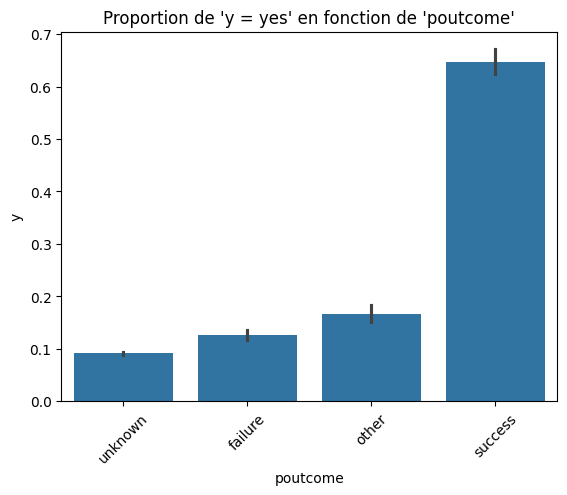

,count
poutcome,
other,38799
failure,4901
success,1511


In [72]:
# bank_data.info()
# bank_data["job"].value_counts()
# bank_data["education"].value_counts()
# bank_data["contact"].value_counts()
# Tableau croisé entre "poutcome" et "y"
poutcome_y_crosstab = pd.crosstab(bank_data["poutcome"], bank_data["y"], normalize="index")
print(poutcome_y_crosstab)

sns.barplot(
    x="poutcome",
    y=(bank_data["y"] == "yes").astype(int),
    data=bank_data
)
plt.title("Proportion de 'y = yes' en fonction de 'poutcome'")
plt.xticks(rotation=45)
plt.show()

bank_data["poutcome"] = bank_data["poutcome"].replace("unknown", "other")
bank_data["poutcome"].value_counts()


Contact présente également un nombre important de unknown. Cependant Son influence sur la target est différente de cellular et telephone. Il est donc preferable de ne pas modifier cette feature pour ne pas perdre d'informations dans notre modèle.

y                no       yes
contact                      
cellular   0.850811  0.149189
telephone  0.865795  0.134205
unknown    0.959293  0.040707


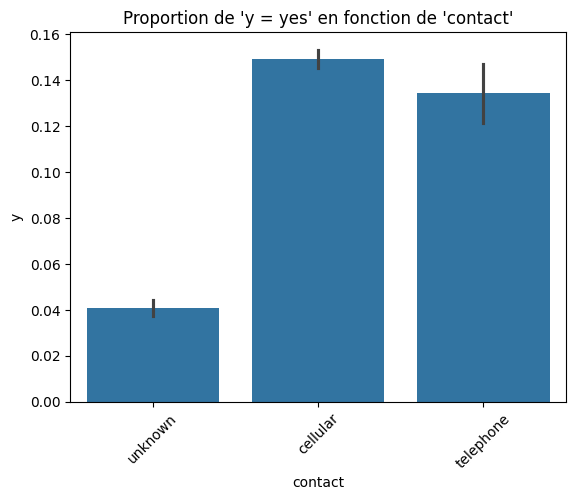

In [73]:
contact_y_crosstab = pd.crosstab(bank_data["contact"], bank_data["y"], normalize="index")
print(contact_y_crosstab)


sns.barplot(
    x="contact",
    y=(bank_data["y"] == "yes").astype(int),
    data=bank_data
)
plt.title("Proportion de 'y = yes' en fonction de 'contact'")
plt.xticks(rotation=45)
plt.show()

3. **Features values distributions, scaling & outliers: possible and chosen strategies to cope with them with arguments**

La distribution des features numériques semble naturelle. Nous n'allons pas y toucher. Cela est également valable pour les potentiels outliers qui seront conservés pour ne pas avoir de perte d'informations car selon nous ils sont du naturels (representatif de la réalité)

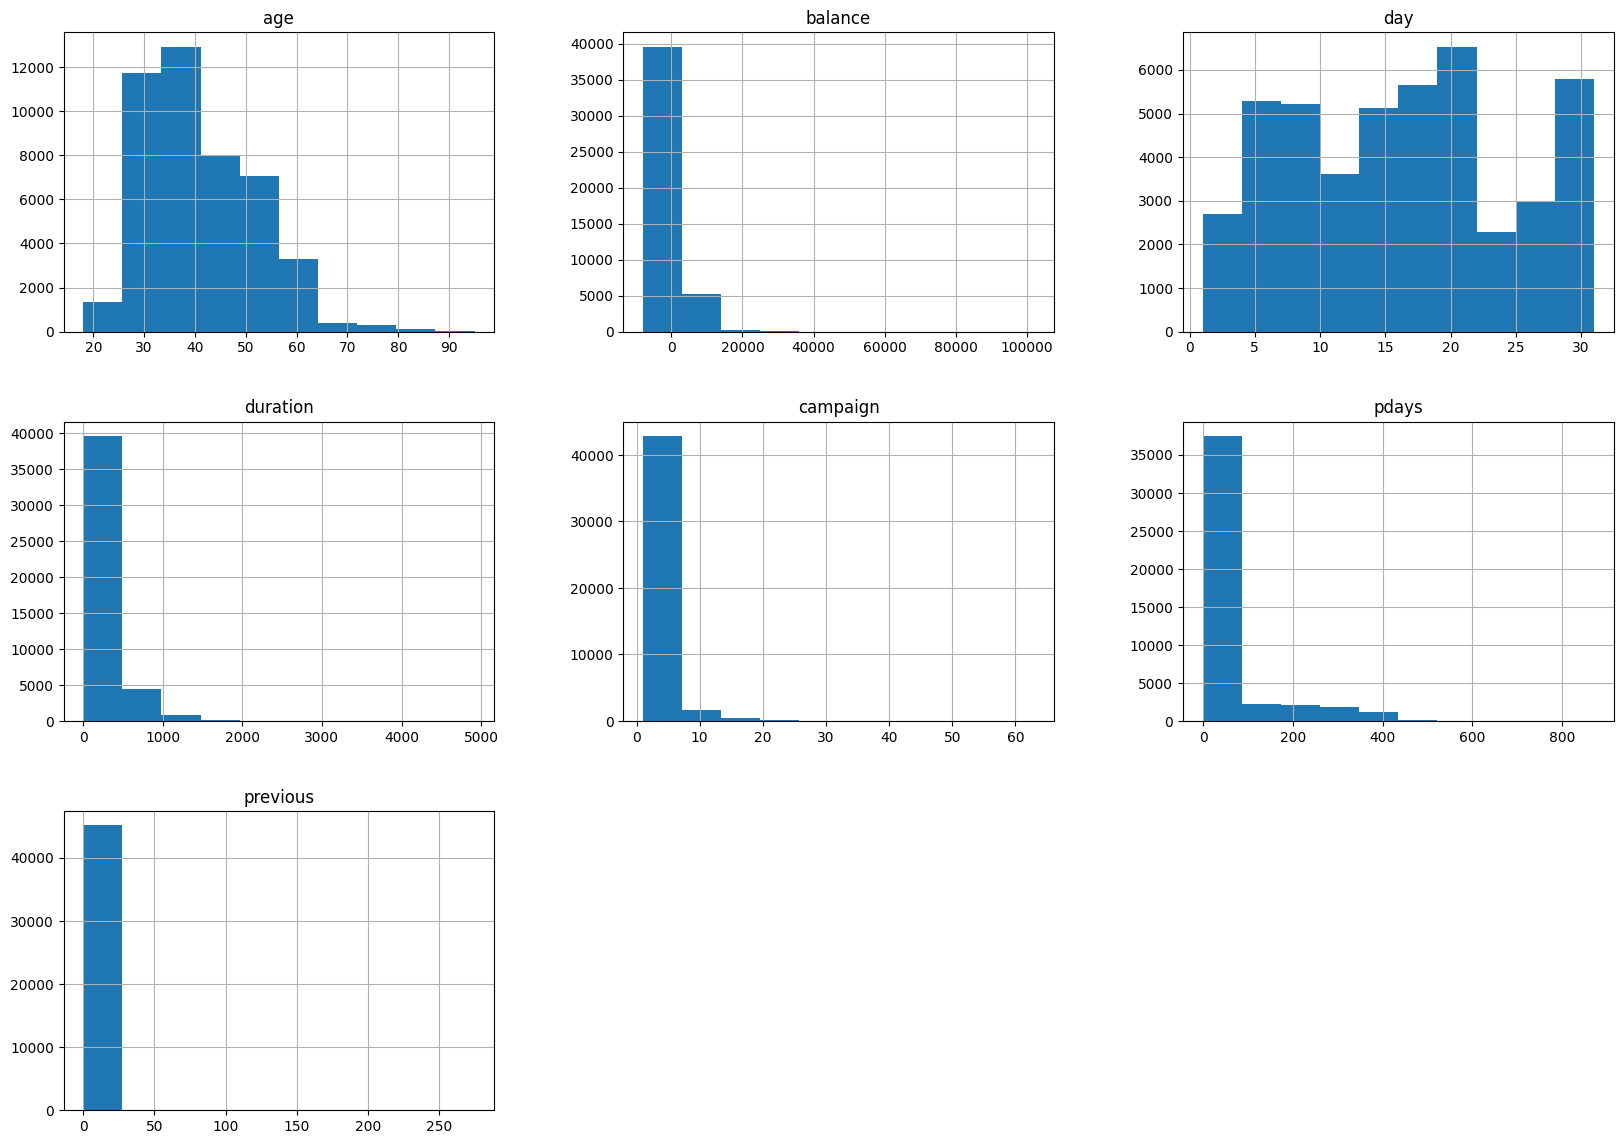

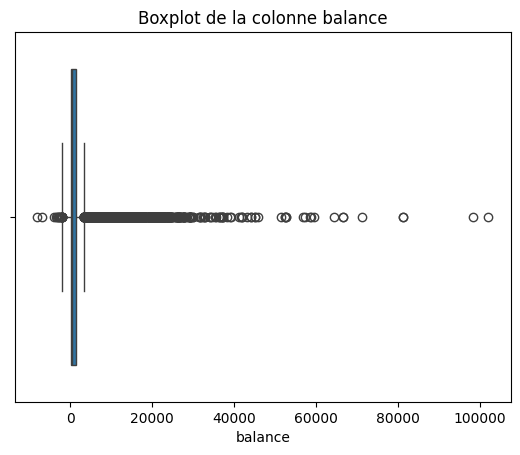

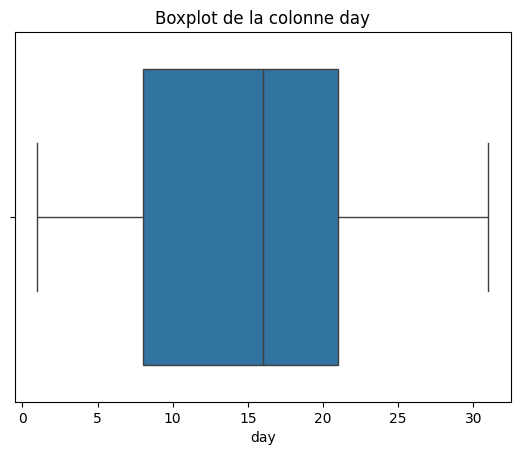

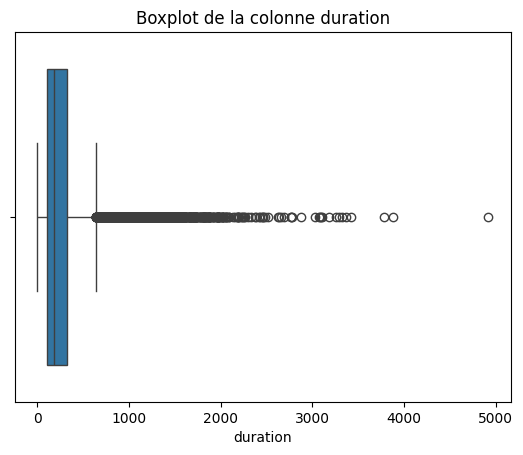

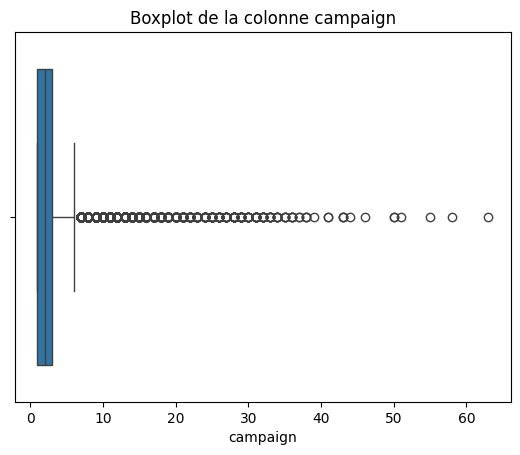

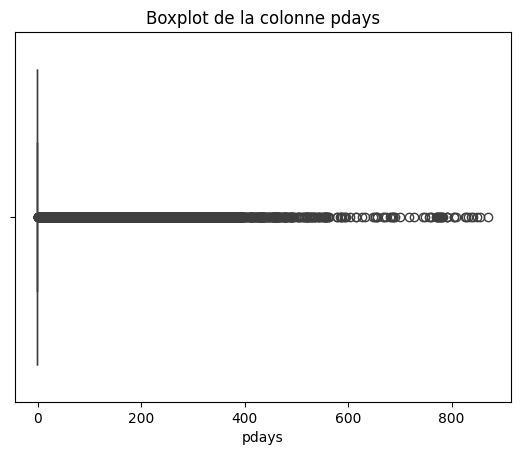

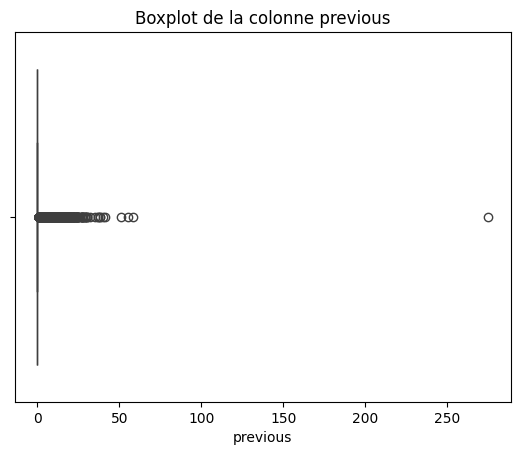

In [74]:
_ = bank_data.hist(figsize=(20, 14))

for feature in numerical_features:
  sns.boxplot(x=bank_data[feature])
  plt.title(f'Boxplot de la colonne {feature}')
  plt.show()


La distribution des features catégoriques
* Certaines features sont déséquilibrés mais car ça représente la réalité

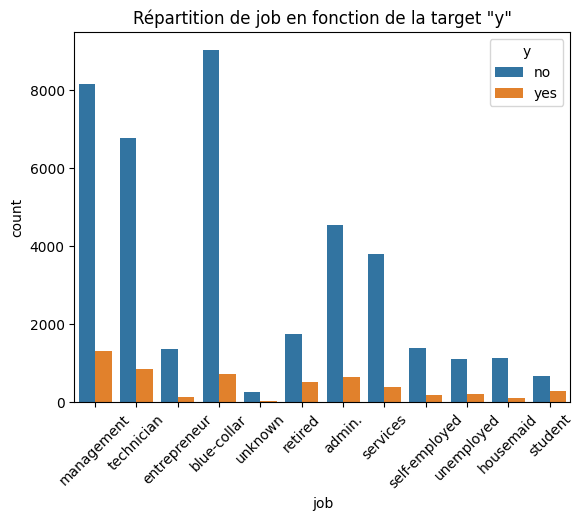

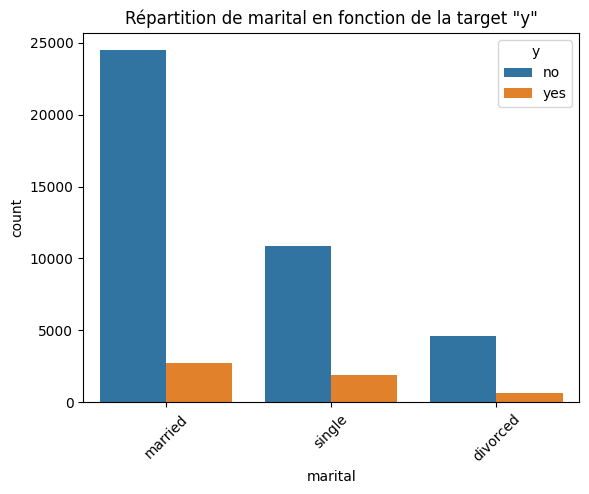

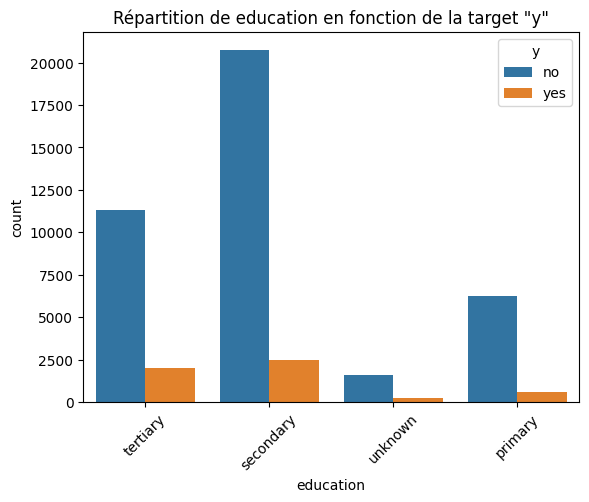

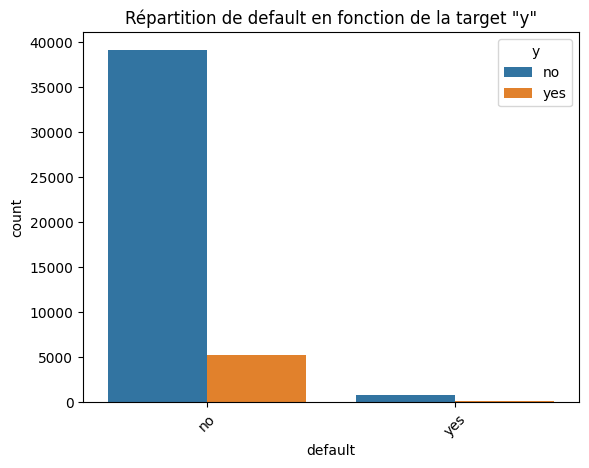

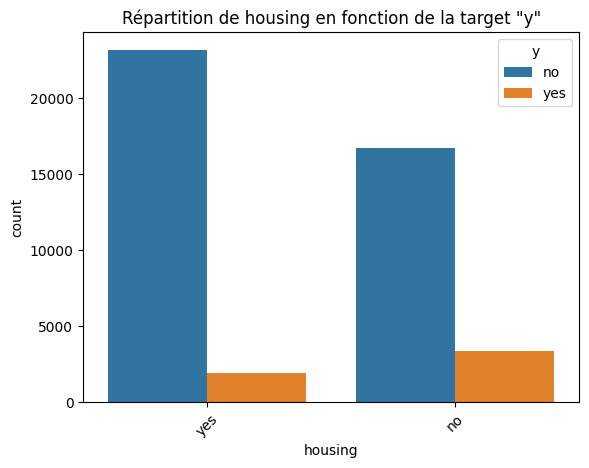

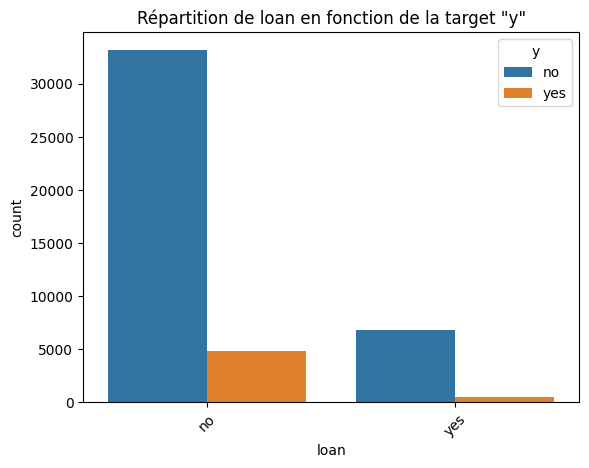

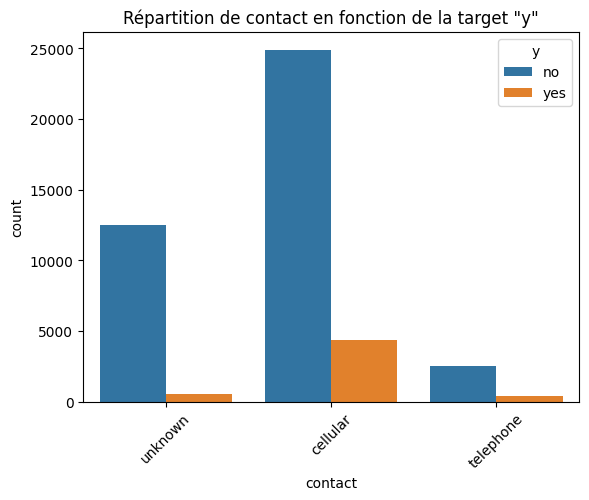

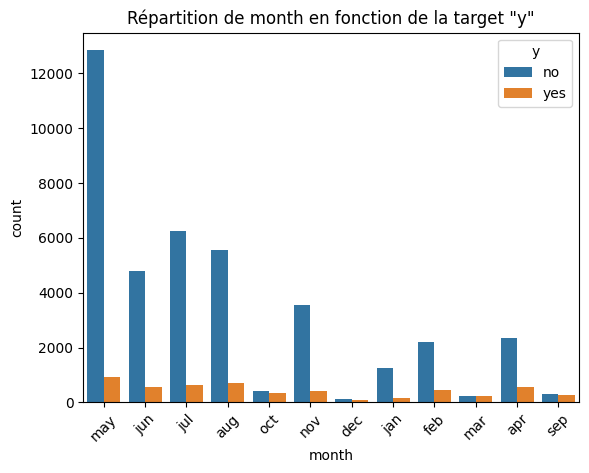

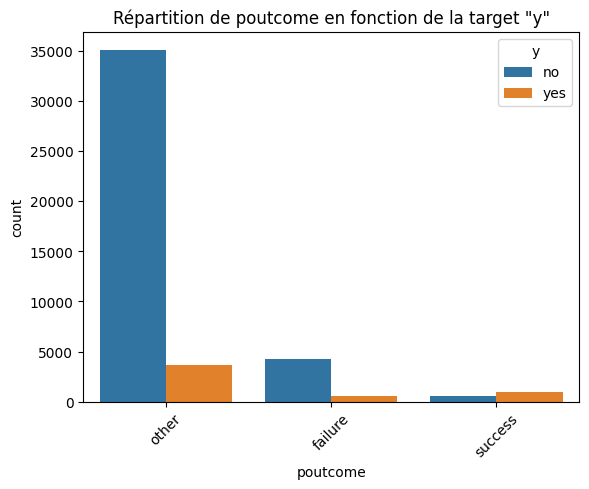

In [75]:
for features in categorical_features:
  sns.countplot(x=features, data=bank_data, hue='y')
  plt.title(f'Répartition de {features} en fonction de la target "y"')
  plt.xticks(rotation=45)
  plt.show()

Etant donné les différences d'echelles des données numériques. Nous allons procéder à un scaling.
Nous utiliseront Standardization pour le scaling car nous avons décidé de ne pas toucher aux outliers et c'est celui qui deal handle le mieu les outliers

note a moi meme : Arbres de décision et forêts aléatoires : Ces modèles ne sont pas sensibles à l'échelle des features, car ils se basent sur des divisions successives des données. Ainsi, le scaling n'est pas nécessaire pour ces modèles.

In [76]:
# Scaling sera fait dans la pipeline

**Target feature study: distribution / class balance, your interpretation & decision to cope with it**

On remarque un fort déséquilibre, c'est un problème car Si une classe est majoritaire, le modèle peut prédire principalement cette classe pour maximiser l'accuracy, tout en ignorant la classe minoritaire.

Ce déséquilibre reflete la réalité car peu de personnes répondent favorablement au démarchage téléphonique.

Pour éviter que le model maximise l'accuracy, on peut faire de l'over sampling mais ça represente un risque egalement on peut aussi faire un random forest avec modification des poids




In [77]:
bank_data[target_column].value_counts()

,count
y,
no,39922
yes,5289


**Features correlation, selection: your explanation,
decision on whether to proceed with different data input in # pipelines**




In [78]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', encoder, categorical_features)
    ]
)

X = bank_data.drop('y', axis=1)
y = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

preprocessor.fit(X)
encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numerical_features + list(encoded_features)

X_transformed = preprocessor.transform(X)
X_transformed_df = pd.DataFrame(X_transformed, columns=all_features)
X_transformed_df['y'] = y

# Calcul de la matrice de corrélation
correlation_matrix = X_transformed_df.corr()

# Vérification des caractéristiques les plus corrélées avec y
correlation_with_y = correlation_matrix['y'].sort_values(ascending=False)
print("Corrélation avec 'y' :\n", correlation_with_y)

features = X_transformed_df.columns


Corrélation avec 'y' :
 y                      1.000000
duration               0.394521
poutcome_success       0.306788
housing_no             0.139173
contact_cellular       0.135873
month_mar              0.129456
month_oct              0.128531
month_sep              0.123185
pdays                  0.103621
previous               0.093236
job_retired            0.079245
job_student            0.076897
month_dec              0.075164
loan_no                0.068185
education_tertiary     0.066448
month_apr              0.065392
marital_single         0.063526
balance                0.052838
month_feb              0.038417
job_management         0.032919
age                    0.025155
default_no             0.022419
job_unemployed         0.020390
contact_telephone      0.014042
education_unknown      0.012053
poutcome_failure       0.009885
job_admin.             0.005637
marital_divorced       0.002772
job_self-employed      0.000855
job_unknown            0.000267
month_aug       

In [79]:
# to do matrix de correlation, selection des features (toutes ou pas ?) + argument

**Interpretations, hypotheses and conclusions**


# **ML Baseline & Ensemble Models**


1. **Training/Validation/Tests Splits**

In [80]:
def testModelFromData(originalData, target, scaler, model, encoder, scalerName, encoderName, scoring):


  numerical_columns_selector = selector(dtype_exclude=object)
  categorical_columns_selector = selector(dtype_include=object)

  numerical_columns = numerical_columns_selector(originalData)
  categorical_columns = categorical_columns_selector(originalData)

  data_train, data_test, target_train, target_test = train_test_split(
      originalData, originalData[target], random_state=0
  )

  categorical_preprocessor = encoder(handle_unknown="ignore")
  numerical_preprocessor = scaler()

  preprocessor = ColumnTransformer([
        (encoderName, categorical_preprocessor, categorical_columns),
        (scalerName, numerical_preprocessor, numerical_columns),  #TO DO : une pré pipeline pour scale cf le cours slide 62
        ]
  )

  modelWithPipeline = make_pipeline(preprocessor, model())
  _ = modelWithPipeline.fit(data_train, target_train)

  modelName = model().__class__.__name__

  cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
  cv_results = cross_validate(
      modelWithPipeline, data_train, target_train, cv=cv, scoring=scoring
  )
  scores = cv_results["test_score"]
  print(
      f"For {modelName}, the mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}"
  )




In [81]:
# k nearest neightbors
scalerName = "standard_scaler"
encoderName = "one-hot-encoder"
scoring = "accuracy"
testModelFromData(bank_data_original, target_column, StandardScaler, KNeighborsClassifier, OneHotEncoder, scalerName, encoderName, scoring)

# random forest classifier
testModelFromData(bank_data_original, target_column, StandardScaler, RandomForestClassifier, OneHotEncoder, scalerName, encoderName, scoring)

For KNeighborsClassifier, the mean cross-validation accuracy is: 0.984 ± 0.001
For RandomForestClassifier, the mean cross-validation accuracy is: 1.000 ± 0.000


Nous obtenons un score de 100% pour le RandomForest, attention cependant, il est possible que le model ai fait de la memorisation